Loading Dataset

In [19]:
import tensorflow_datasets as tfds
(train_ds, val_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)


In [20]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(1)


Loading Pretained Based Model

Mobilenet V2

In [21]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False


In [22]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes for RPS
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6482 - loss: 0.7826 - val_accuracy: 0.9861 - val_loss: 0.1171 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9665 - loss: 0.1436 - val_accuracy: 0.9960 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9942 - loss: 0.0658 - val_accuracy: 1.0000 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9925 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9956 - loss: 0.0370 - val_accuracy: 1.0000 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9999 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9991 - loss: 0.0206 - val_accurac

In [42]:
base_model.trainable = True
# Fine-tune last N layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 3.9286e-04 - learning_rate: 1.0000e-05
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 1.0000 - loss: 7.6364e-04 - val_accuracy: 1.0000 - val_loss: 6.4700e-04 - learning_rate: 1.0000e-05
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 1.0000 - loss: 2.3710e-04 - val_accuracy: 1.0000 - val_loss: 5.6670e-04 - learning_rate: 1.0000e-05
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 1.0000 - loss: 1.9245e-04 - val_accuracy: 1.0000 - val_loss: 5.2190e-04 - learning_rate: 1.0000e-05
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 1.0000 - loss: 3.6023e-04 - val_accuracy: 1.0000 - val_loss: 3.8257e-04 - learning_rate: 1.0000e-06
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 1.0000 - loss: 2.5815e-04 - val_accuracy: 1.0000 - val_loss: 3.0483e-04 - learning_rate: 1.0000e-06
Epoch 7/10
63/63 ━━━━━━━━━

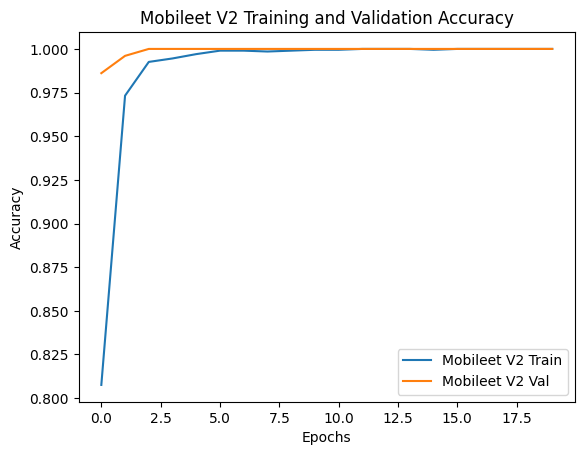

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Mobileet V2 Train')
plt.plot(history.history['val_accuracy'], label='Mobileet V2 Val')
plt.title('Mobileet V2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [40]:
test_loss_mv2, test_acc_mnv2 = model.evaluate(val_ds)
print(f"Final Test Accuracy: {test_acc_mnv2:.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 9.6027e-04
Final Test Accuracy: 1.00


Resnet50

In [26]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


In [27]:
def preprocess_resnet(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return resnet_preprocess(image), label

train_ds_resnet = train_ds.map(lambda x, y: preprocess_resnet(x, y)).prefetch(1)
val_ds_resnet = val_ds.map(lambda x, y: preprocess_resnet(x, y)).prefetch(1)


In [28]:
from tensorflow.keras.applications import ResNet50

# Load base model
resnet_base = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
resnet_base.trainable = False  # freeze base

# Build model
resnet_model = tf.keras.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)

history_resnet = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 413s 6s/step - accuracy: 0.6013 - loss: 0.8927 - val_accuracy: 0.9405 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 402s 6s/step - accuracy: 0.9183 - loss: 0.3865 - val_accuracy: 0.9663 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 432s 6s/step - accuracy: 0.9580 - loss: 0.2651 - val_accuracy: 0.9722 - val_loss: 0.2201 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 393s 6s/step - accuracy: 0.9721 - loss: 0.2039 - val_accuracy: 0.9802 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - accuracy: 0.9734 - loss: 0.1725 - val_accuracy: 0.9901 - val_loss: 0.1463 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 445s 6s/step - accuracy: 0.9661 - loss: 0.1616 - val_accuracy: 0.9901 - val_loss: 0.1265 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 0.9782 - loss: 0.1312 - val_acc

In [30]:
resnet_base.trainable = True

# Fine-tune top N layers
fine_tune_at = 100
for layer in resnet_base.layers[:fine_tune_at]:
    layer.trainable = False

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_resnet_fine = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 806s 12s/step - accuracy: 0.7301 - loss: 3.2514 - val_accuracy: 0.9365 - val_loss: 0.1446 - learning_rate: 1.0000e-05
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 770s 12s/step - accuracy: 0.9975 - loss: 0.0043 - val_accuracy: 0.9782 - val_loss: 0.0635 - learning_rate: 1.0000e-05
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 797s 12s/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 803s 12s/step - accuracy: 0.9950 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 5.4149e-05 - learning_rate: 1.0000e-05
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 802s 12s/step - accuracy: 0.9992 - loss: 8.8593e-04 - val_accuracy: 1.0000 - val_loss: 2.2718e-06 - learning_rate: 1.0000e-05
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 770s 12s/step - accuracy: 0.9997 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 5.0072e-07 - learning_rate: 1.0000e-05
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 796s 12s/s

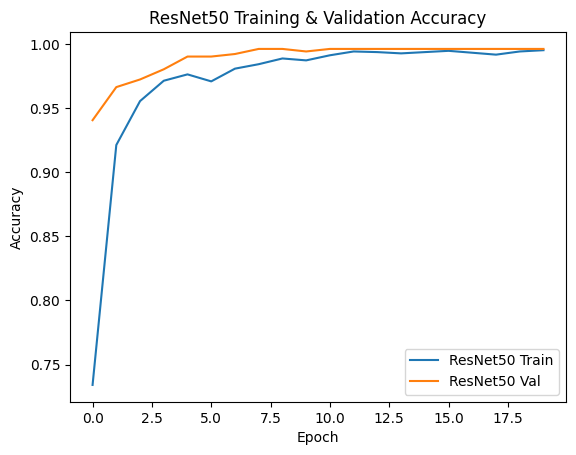

In [31]:
import matplotlib.pyplot as plt

plt.plot(history_resnet.history['accuracy'], label='ResNet50 Train')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 Val')
plt.title('ResNet50 Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [32]:
test_loss_rn, test_acc_rn = resnet_model.evaluate(val_ds_resnet)
print(f"ResNet50 Final Accuracy: {test_acc_rn:.2f}")



16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 1.0000 - loss: 1.6974e-07
ResNet50 Final Accuracy: 1.00


In [34]:
print(f"MobileNetV2 Accuracy: {test_acc_mnv2:.2f}")
print(f"ResNet50 Accuracy: {test_acc_rn:.2f}")


ResNet50 Accuracy: 1.00


In [41]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["MobileNetV2", "ResNet50"],
    "Validation Accuracy": [test_acc_mnv2, test_acc_rn],
    "Parameters": ["~3.5M", "~25.6M"],
    "Model Size": ["~14MB", "~98MB"],
    "Notes": ["Fast inference", "More accurate, heavier"]
})

print(results_df)


         Model  Validation Accuracy Parameters Model Size  \
0  MobileNetV2                  1.0      ~3.5M      ~14MB   
1     ResNet50                  1.0     ~25.6M      ~98MB   

                    Notes  
0          Fast inference  
1  More accurate, heavier  
